In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import h5py
from sklearn.linear_model import Ridge, Lasso, LassoCV, LassoLarsCV, LinearRegression, BayesianRidge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
# import statsmodels.api as sm
# from patsy import dmatrix

# Here we are importing the h5 file and create a dataframe.

In [2]:
file = h5py.File('Data_Fuchs_v_2.7_Wright_Pat_Narrow_Range_energy_limit_0.01_deviation_0.0_lambda_um_0.8_points_100000_seed_3.h5','r')
file_dict = dict()
for i in file.keys():
    file_dict[i] = file[i][:]
file.close()
physics = pd.DataFrame(file_dict)

# Here we specify the input and output variables

In [3]:
outputs = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)']

In [4]:
# this is to avoid copying a pasting
inputs = []
for i in physics.columns:
    if i in outputs:
        continue
    else:
        inputs.append(i)
inputs

['Intensity_(W_cm2)',
 'Pulse_Duration_(fs)',
 'Spot_Size_(FWHM um)',
 'Target_Thickness (um)']

##### Scatter plot of total energy protons with the input variables.

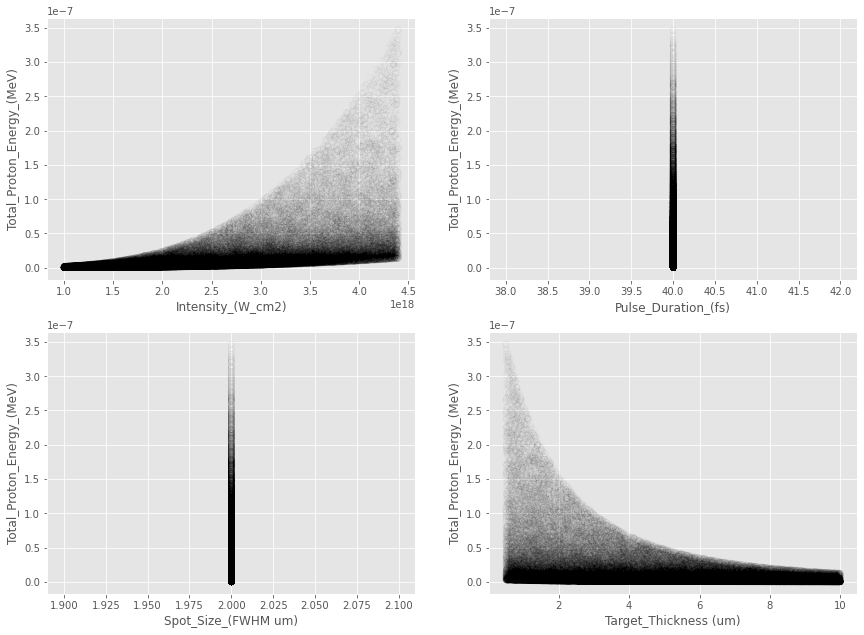

In [5]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(physics[inputs[0]],physics[outputs[1]], facecolor='None', edgecolor='k', alpha=0.035)
axs[0, 0].set(xlabel=f'{inputs[0]}', ylabel=f'{outputs[1]}')

axs[0, 1].scatter(physics[inputs[1]], physics[outputs[1]], facecolor='None', edgecolor='k', alpha=0.035)
axs[0, 1].set(xlabel=f'{inputs[1]}', ylabel=f'{outputs[1]}')

axs[1, 0].scatter(physics[inputs[2]], physics[outputs[1]], facecolor='None', edgecolor='k', alpha=0.035)
axs[1, 0].set(xlabel=f'{inputs[2]}', ylabel=f'{outputs[1]}')

axs[1, 1].scatter(physics[inputs[3]], physics[outputs[1]], facecolor='None', edgecolor='k', alpha=0.035)
axs[1, 1].set(xlabel=f'{inputs[3]}', ylabel=f'{outputs[1]}')

plt.subplots_adjust(bottom=1, right=2, top=3)

##### creating new dataframe with total energy protons as the only output variable.

In [6]:
df = physics.copy()
df.drop(outputs[0], axis= 1, inplace= True)
df.drop(outputs[2], axis= 1, inplace= True)

##### Creating the training and testing data sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[inputs], df[outputs[1]], test_size=0.33, random_state=0)

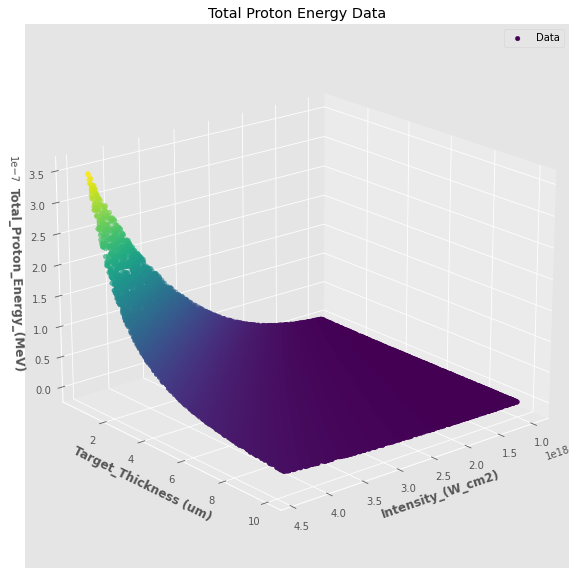

In [8]:
fig1 = plt.figure(figsize=(10, 10))
ax = fig1.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_train,
           c = y_train,
           label= 'Data')
ax.set_title('Total Proton Energy Data')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[1]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

##### The following is a scatter plot of log(total proton energy).

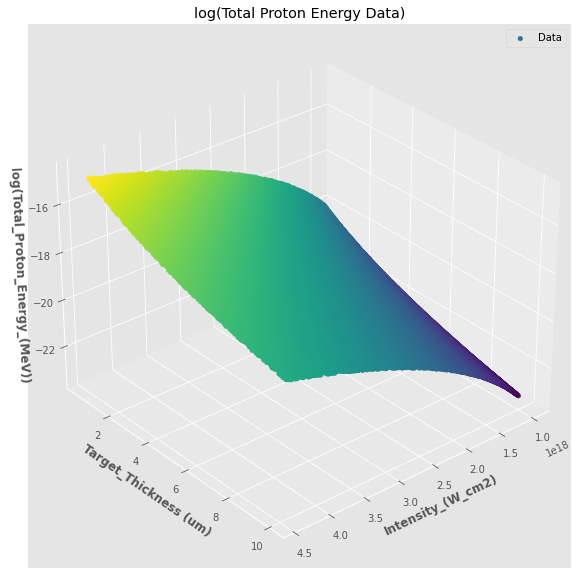

In [9]:
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           np.log(y_train),
           c = np.log(y_train),
           label= 'Data')
ax.set_title('log(Total Proton Energy Data)')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'log({outputs[1]})', fontweight ='bold')
ax.view_init(30, 50)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

##### Creating the log spline model for total proton energy.

In [10]:
start_time = time.process_time()

In [11]:
spline_tpe_int_tt_var_log = make_pipeline(SplineTransformer(n_knots=10, degree=3), Ridge(alpha=.001))

In [12]:
spline_tpe_int_tt_var_log.fit(X_train[[inputs[0], inputs[3]]], np.log(y_train))

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=10)),
                ('ridge', Ridge(alpha=0.001))])

In [13]:
y_tpe_int_tt_var_model_var_log = spline_tpe_int_tt_var_log.predict(X_train[[inputs[0], inputs[3]]])

##### CPU time for spline log model for total proton energy.

In [14]:
end_time = time.process_time()
print(f'The CPU time for this model to run is {end_time - start_time} seconds.')
del start_time
del end_time

The CPU time for this model to run is 0.3110730000000004 seconds.


##### Mean squared error of the y testing set of the log spline model using the X testing set

In [15]:
mean_squared_error(np.log(y_test),
                   spline_tpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]])
                   )

0.00013363380473602638

##### Scatter plot of the predictions of the X training set compared to the y training set

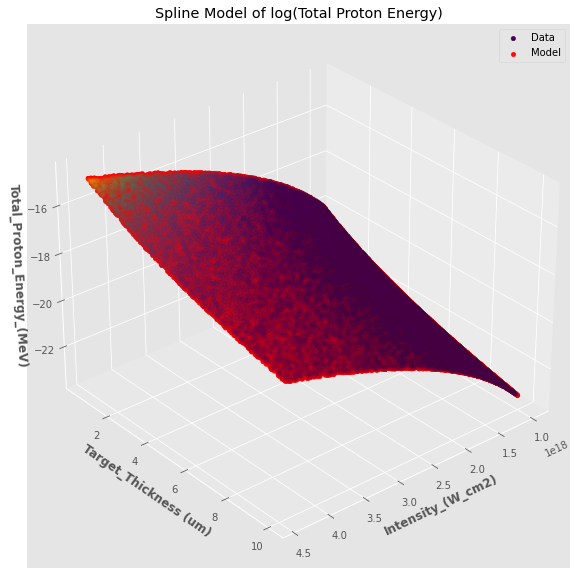

In [26]:
fig3 = plt.figure(figsize=(10, 10))
ax = fig3.add_subplot(projection='3d')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           np.log(y_train),
           c = y_train/ (np.log(X_train[inputs[0]] + X_train[inputs[3]]))**9,
           alpha= .05,
           label= 'Data')
ax.scatter(X_train[inputs[0]],
           X_train[inputs[3]],
           y_tpe_int_tt_var_model_var_log,
           c = 'red',
           alpha= .95,
           label= 'Model')
ax.set_title('Spline Model of log(Total Proton Energy)')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[1]}', fontweight ='bold')
ax.view_init(30, 50)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

##### Creating the relative error plots of the spline model for total proton energy using the testing X and y sets.

In [17]:
error_series_log = np.abs((np.log(y_test) - spline_tpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]])) / np.log(y_test))
error_3d_log = X_test[[inputs[0], inputs[3]]].copy()
error_3d_log['Relative Error'] = error_series_log
error_3d_log['prediction in log'] = spline_tpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]])
error_3d_log['converted prediction'] = np.exp(spline_tpe_int_tt_var_log.predict(X_test[[inputs[0], inputs[3]]]))
error_3d_log['Relative Error of Original y_test'] = np.abs((error_3d_log['converted prediction'] - y_test) / y_test)

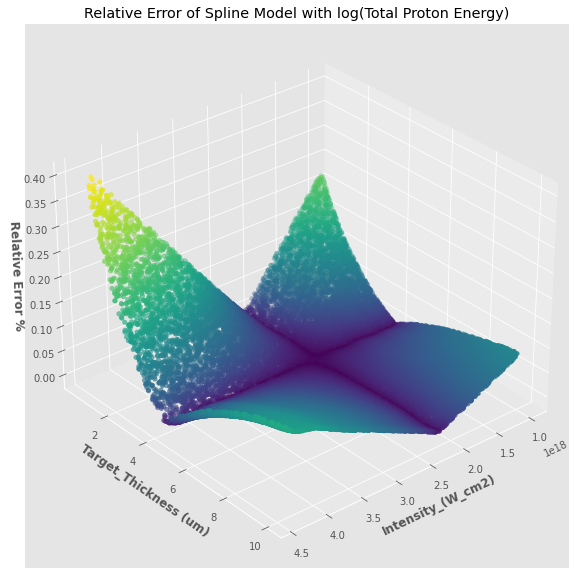

In [25]:
fig4 = plt.figure(figsize=(10, 10))
ax = fig4.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d_log['Relative Error'] * 100,
           c = np.sqrt(error_3d_log['Relative Error']))
ax.set_title('Relative Error of Spline Model with log(Total Proton Energy)')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(30, 50)
plt.show()

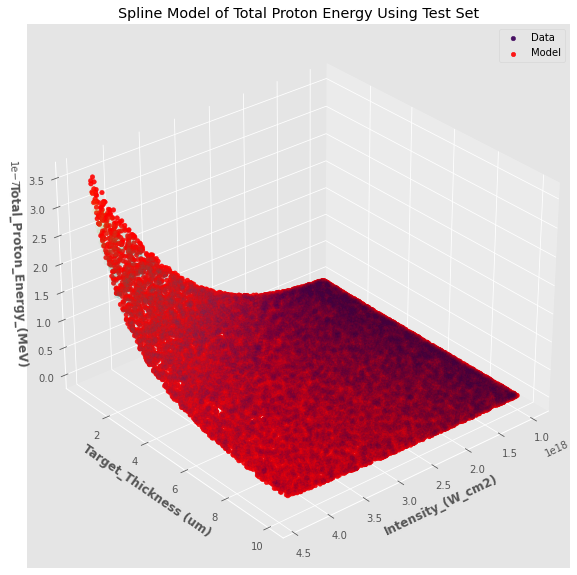

In [24]:
fig5 = plt.figure(figsize=(10, 10))
ax = fig5.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           y_test,
           c = y_test,
           alpha= .05,
           label= 'Data')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d_log['converted prediction'],
           c = 'red',
           alpha= .90,
           label= 'Model')
ax.set_title('Spline Model of Total Proton Energy Using Test Set')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[1]}', fontweight ='bold')
ax.view_init(30, 50)
plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_alpha(1)
plt.show()

##### Scatter plot of the relative error of exp(log(total proton energy)) compared to y_test

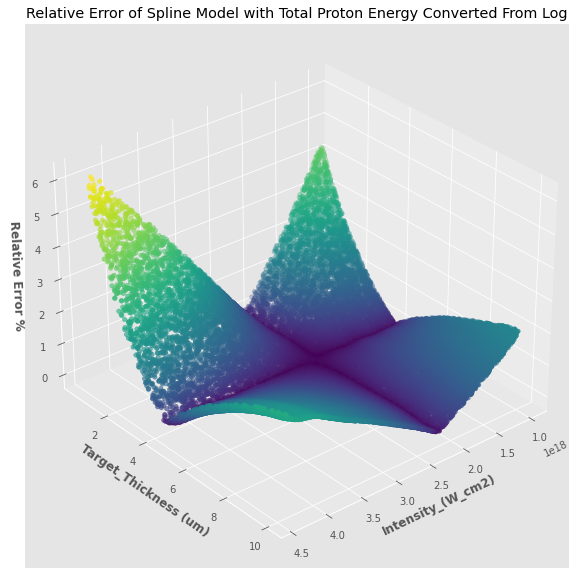

In [23]:
fig6 = plt.figure(figsize=(10, 10))
ax = fig6.add_subplot(projection='3d')
ax.scatter(X_test[inputs[0]],
           X_test[inputs[3]],
           error_3d_log['Relative Error of Original y_test'] * 100,
           c = np.sqrt(error_3d_log['Relative Error']))
ax.set_title('Relative Error of Spline Model with Total Proton Energy Converted From Log')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[3]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(30, 50)
plt.show()

In [21]:
mean_squared_error(y_test, error_3d_log['converted prediction'])

1.5199515927707086e-18